# Final Results - <b>Mechanosensing = True || Bell = True</b>


In [2]:
### IMPORT LIBRARIES ###
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import h5py
from mpl_toolkits.mplot3d import Axes3D  
import itertools
from scipy.signal import find_peaks

### FIGURE STYLE ###
sns.set()
sns.set_style("white")
sns.set_context("notebook")
sns.set_palette("hls", 8)

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [3]:
### FUNCTIONS DEFINITON ###
# Plot cell nodes in a user-defined timestep
def getCoordinates(sample_number, timestep_number):
    
    # Initialize vector to save nodes' coordinates
    coord = pd.DataFrame(np.nan, index=range(0, 2562), columns=range(0,3))
    
    # Read VTK file
    mesh = open('AON_FON/extract_files/sample_' + str(sample_number).zfill(2) + '/samp_data_' + str(timestep_number) + '.vtk')
    lines = mesh.readlines()
    
    # Read lines containing information about the coordinates
    old_array = np.fromstring(lines[5], sep=' ')
    for n in range(6, 859):

        temp_array = np.fromstring(lines[n], dtype=float, sep=' ')

        old_array = np.concatenate((old_array, temp_array))
    
    # Sorting x, y and z coordinates into the correct column in coordinates DataFrame
    coord.iloc[:,0] = old_array[0::3]
    coord.iloc[:, 1] = old_array[1::3]
    coord.iloc[:, 2] = old_array[2::3]
    
    return coord
    
def plotNodes(sample_number, timestep_number, mode = 'XY'):
    
    # Get coordinates
    coord = getCoordinates(sample_number, timestep_number)

    # Plot the nodes in a scatter plot
    if mode == 'XY': 
        sns.scatterplot(coord[coord[2] <= 0][0], coord[coord[2] <= 0][1], label = timestep_number)
         
        # Figure aesthetics
        plt.xlim(-7.5e-5, -2e-5)
        plt.ylim(-1e-7, 7e-6)
    
    elif mode == 'XZ':
        sns.scatterplot(coord[coord[1] > 1e-7][0], coord[coord[1] > 1e-7][2], label = timestep_number)
        
        # Figure aesthetics
        plt.xlim(-7.5e-5, -2e-5)
        plt.ylim(-1.2e-5, 1.2e-5)
    
    else:
        sns.scatterplot(coord[1], coord[1], label = timestep_number)

In [5]:
### READING THE RESULTS INTO A DATAFRAME ###
path = 'AON_FON/pstudy/'

# Reading the first results file
f = h5py.File(path + '/001/pstudy.h5', 'r')

# Storing the parameters (kECM and pFA_rev) in a DataFrame
params = pd.DataFrame(0.0, index=range(0, 24), columns=['samp_num','kECM', 'pFA_rev'])

params['samp_num'] = range(0,24)
params['kECM'] = f['results']['params']['kECM']['data'].value
params['pFA_rev'] = f['results']['params']['pFA_rev']['data'].value

data = pd.DataFrame(0.0, index = range(0, 710*24*5), columns = ['time', 'sim_num', 'samp_num', 'kECM', 'pFA_rev', 'nFA', 'lt_FA', 'multFam',
                                                            'rpdFA', 'trac_cell', 'CoM', 'sum_disp', 'diff_disp', 'final_disp', 'abs_disp'])

# Going through all .h5 files to get the results
for m in range(0, 5):
    
    f = h5py.File(path + str(m + 1).zfill(3) +'/pstudy.h5', 'r')
    
    for n in range(0, 24):
        
        data['time'][m*24*710 + (n*710) : m*24*710 + (n*710) + 710] = np.arange(0, 710*2, 2)
        data['pFA_rev'][m*24*710 + (n*710) : m*24*710 + (n*710) + 710] = params['pFA_rev'][n]
        data['kECM'][m*24*710 + (n*710) : m*24*710 + (n*710) + 710] = params['kECM'][n]
        data['sim_num'][m*24*710 + (n*710) : m*24*710 + (n*710) + 710] = m + 1
        data['samp_num'][m*24*710 + (n*710) : m*24*710 + (n*710) + 710] = n
    
        data['nFA'][m*24*710 + (n*710) : m*24*710 + (n*710) + 710] = f['results']['sim_output']['nFA']['data'][n, 0:710]
        data['lt_FA'][m*24*710 + (n*710) : m*24*710 + (n*710) + 710] = f['results']['sim_output']['lt_FA']['data'][n, 0:710]
        data['multFam'][m*24*710 + (n*710) : m*24*710 + (n*710) + 710] = f['results']['sim_output']['multFam']['data'][n, 0:710]
        data['rpdFA'][m*24*710 + (n*710) : m*24*710 + (n*710) + 710] = f['results']['sim_output']['rpdFA']['data'][n, 0:710]
        data['trac_cell'][m*24*710 + (n*710) : m*24*710 + (n*710) + 710] = f['results']['sim_output']['trac_cell']['data'][n, 0:710]
        data['CoM'][m*24*710 + (n*710) : m*24*710 + (n*710) + 710] = f['results']['sim_output']['CoM']['data'][:,:,0][n, 0:710]
        
        diff_disp = np.diff(f['results']['sim_output']['CoM']['data'][:,:,0][n, 0:710])*10e5
        cum_sum = np.cumsum(np.diff(f['results']['sim_output']['CoM']['data'][:,:,0][n, 0:710]))*10e5
        
        data['diff_disp'][m*24*710 + (n*710) + 1 : m*24*710 + (n*710) + 710] = diff_disp
        data['sum_disp'][m*24*710 + (n*710) + 1 : m*24*710 + (n*710) + 710] = cum_sum
        data['abs_disp'][m*24*710 + (n*710) + 1 : m*24*710 + (n*710) + 710] = cum_sum
        
        final_disp = np.mean(cum_sum[-5:]) 
        
        data['final_disp'][m*24*710 + (n*710) : m*24*710 + (n*710) + 710] = final_disp
        

## <b> Displacement </b>
The first metric to be analyzed will be the **displacement of the cell's center of mass**, considering the x axis, as this is the axis in which the cell's movement is more dominant. In order to ease the comprehension of this data, the figures below represent the cell cortex's nodes at the start and at the end of the simulation, for the sample that migrates the most.

(-7.5e-05, -2e-05)

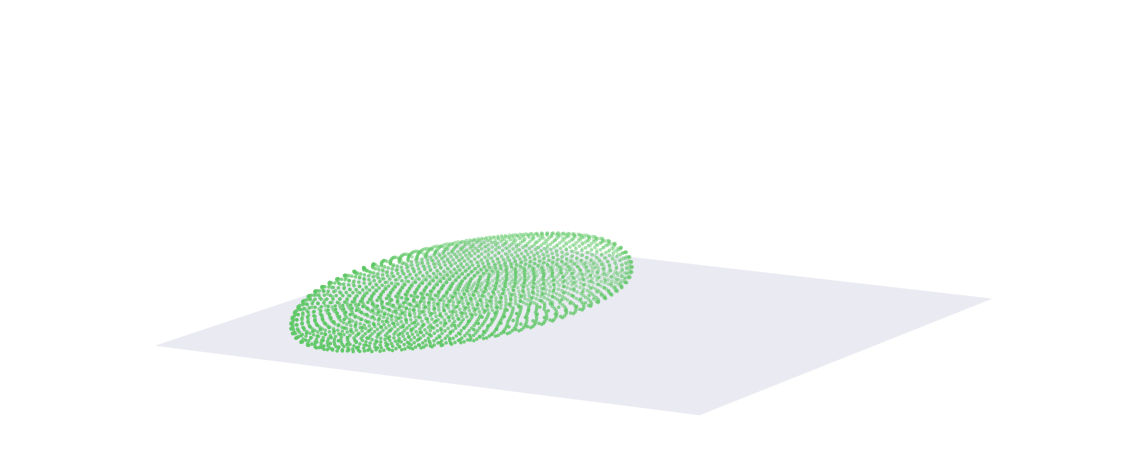

In [6]:
### PLOT NODES - START OF SIMULATION ###
# Figure definition
sns.set_style('white')
sns.set_palette("viridis_r", 3)
fig = plt.figure(figsize = (20,8))
ax = fig.gca(projection='3d')
ax._axis3don = True

# User-defined parameters (sample and timestep)
samp_num = 20
time_num = 0

# Get coordinates from VTK files
coord = getCoordinates(samp_num, time_num)

# Plot nodes
ax.scatter(coord[0], coord[2], coord[1], s = 11)

# Figure aesthetics
# Hide grid lines
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# Get rid of the panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((0.917, 0.917, 0.949, 1.0))
# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
# Limits
ax.set_zlim(0, 1.5e-5)
ax.set_xlim(-7.5e-5, -2e-5)
#ax.set_title("Cell cortex nodes at the start of the simulation", weight = 'bold')

Text(0.5,0.92,'Cell cortex nodes at the end of the simulation')

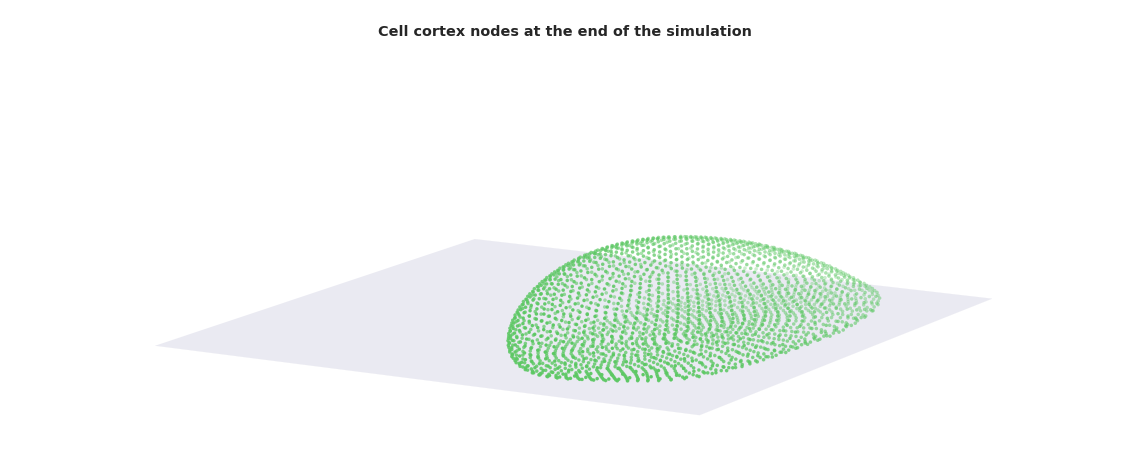

In [265]:
### PLOT NODES - END OF SIMULATION ###
# Figure definition
sns.set_style('white')
sns.set_palette("viridis_r", 3)
fig = plt.figure(figsize = (20,8))
ax = fig.gca(projection='3d')
ax._axis3don = True

# User-defined parameters (sample and timestep)
samp_num = 20
time_num = 710

# Get coordinates from VTK files
coord = getCoordinates(samp_num, time_num)

# Plot nodes
ax.scatter(coord[0], coord[2], coord[1], s = 11)

# Figure aesthetics
# Hide grid lines
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# Get rid of the panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((0.917, 0.917, 0.949, 1.0))
# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
# Limits
ax.set_zlim(0, 1.5e-5)
ax.set_xlim(-7.5e-5, -2e-5)
# Title
ax.set_title("Cell cortex nodes at the end of the simulation", weight = 'bold')

To get a better notion of the movement through time, the figure below shows the cell's position at the start, middle and end of the simulation.

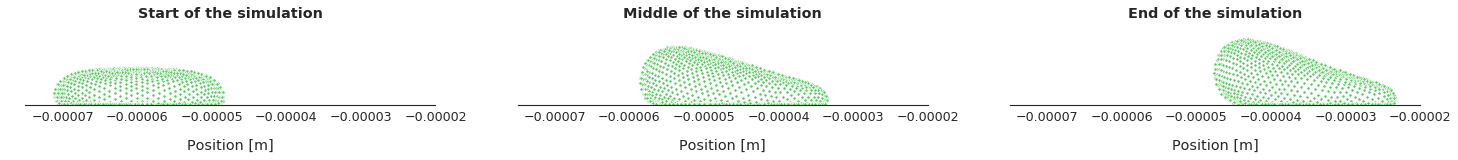

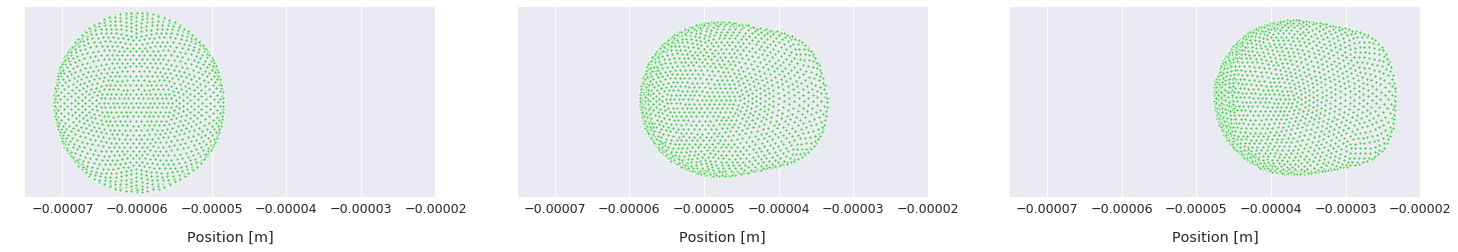

In [259]:
### PLOT DISPLACEMENT 2D THROUGH TIME ###
sns.set_style('white')
fig, ax = plt.subplots(1, 3, sharey = 'row', sharex = True, figsize = (25,1.5))

samp_num = 20

time_num = 0

# Get coordinates from VTK files and plot them
coord = getCoordinates(samp_num, time_num)

sns.scatterplot(coord[coord[2] <= 0][0], coord[coord[2] <= 0][1], ax = ax[0], s=11)

time_num = 350

# Get coordinates from VTK files and plot them
coord = getCoordinates(samp_num, time_num)

sns.scatterplot(coord[coord[2] <= 0][0], coord[coord[2] <= 0][1], ax = ax[1], s=11)

time_num = 700

# Get coordinates from VTK files and plot them
coord = getCoordinates(samp_num, time_num)

sns.scatterplot(coord[coord[2] <= 0][0], coord[coord[2] <= 0][1], ax = ax[2], s=11)

# Figure aesthetics
ax[0].set_xlim(-7.5e-5, -2e-5)
ax[0].set_ylim(-1e-7, 7e-6)
ax[0].set_yticks([])
ax[0].set_ylabel(' ')
ax[0].set_xlabel('Position [m]', labelpad = 15)
ax[1].set_xlabel('Position [m]', labelpad = 15)
ax[2].set_xlabel('Position [m]', labelpad = 15)
ax[0].set_title('Start of the simulation', weight = 'bold')
ax[1].set_title('Middle of the simulation', weight = 'bold')
ax[2].set_title('End of the simulation', weight = 'bold')
sns.despine(fig, left = True)

sns.set_style('darkgrid')
fig, ax = plt.subplots(1, 3, sharey = 'row', sharex = True, figsize = (25,3.5))

time_num = 0

# Get coordinates from VTK files and plot them
coord = getCoordinates(samp_num, time_num)

sns.scatterplot(coord[coord[1] > 1e-7][0], coord[coord[1] > 1e-7][2], ax = ax[0], s=11)

time_num = 350

# Get coordinates from VTK files and plot them
coord = getCoordinates(samp_num, time_num)

sns.scatterplot(coord[coord[1] > 1e-7][0], coord[coord[1] > 1e-7][2], ax = ax[1], s=11)

time_num = 700

# Get coordinates from VTK files and plot them
coord = getCoordinates(samp_num, time_num)

sns.scatterplot(coord[coord[1] > 1e-7][0], coord[coord[1] > 1e-7][2], ax = ax[2], s=11)

# Figure aesthetics
ax[0].set_xlim(-7.5e-5, -2e-5)
ax[0].set_ylim(-1.2e-5, 1.2e-5)
ax[0].set_yticks([])
ax[0].set_ylabel(' ')
ax[0].set_xlabel('Position [m]', labelpad = 15)
ax[1].set_xlabel('Position [m]', labelpad = 15)
ax[2].set_xlabel('Position [m]', labelpad = 15)
sns.despine(fig, left = True)

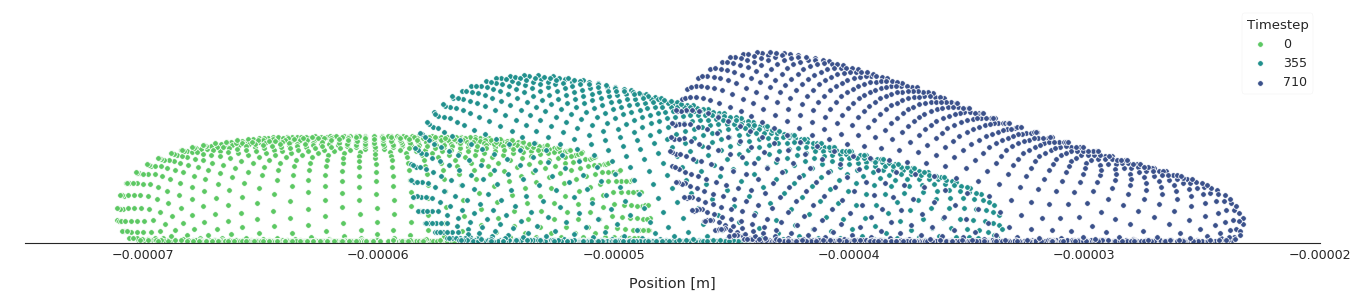

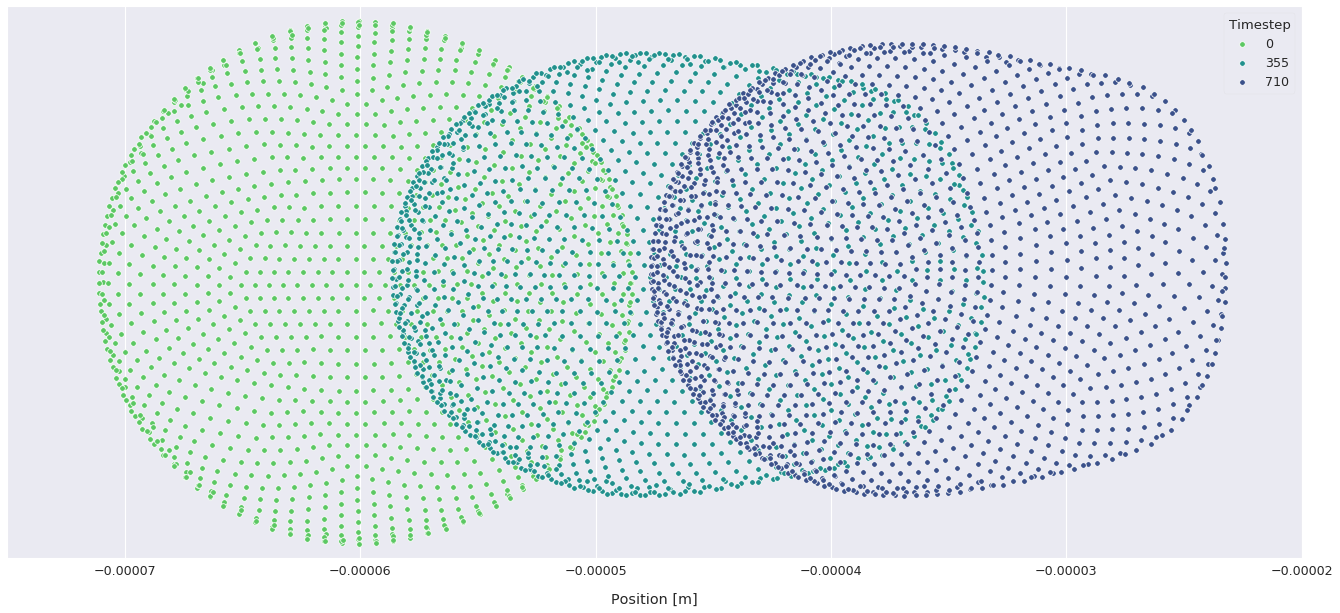

In [269]:
### PLOT CELL NODES - 2D ###
sns.set_style('white')
plt.figure(figsize = (8*2.9,1.5*2.9))
sns.set_palette("viridis_r", 3)

plotNodes(20, 0)
plotNodes(20, 355)
plotNodes(20, 710)

sns.despine(left = True)
plt.yticks([])
plt.ylabel(' ')
plt.xlabel('Position [m]', labelpad = 15)
plt.legend(title = 'Timestep')

sns.set_style('darkgrid')
plt.figure(figsize = (8*2.9,3.5*2.9))
sns.set_palette("viridis_r", 3)

sns.despine(left = True)
plt.yticks([])
plt.ylabel(' ')
plotNodes(20, 0, 'XZ')
plotNodes(20, 355, 'XZ')
plotNodes(20, 710, 'XZ')
plt.xlabel('Position [m]', labelpad = 15)
plt.legend(title = 'Timestep')

/home/ines/python_envs/generic/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/ines/python_envs/generic/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Text(-4.72921e-05,6.8e-06,'Final displacement: 25.46 nm')

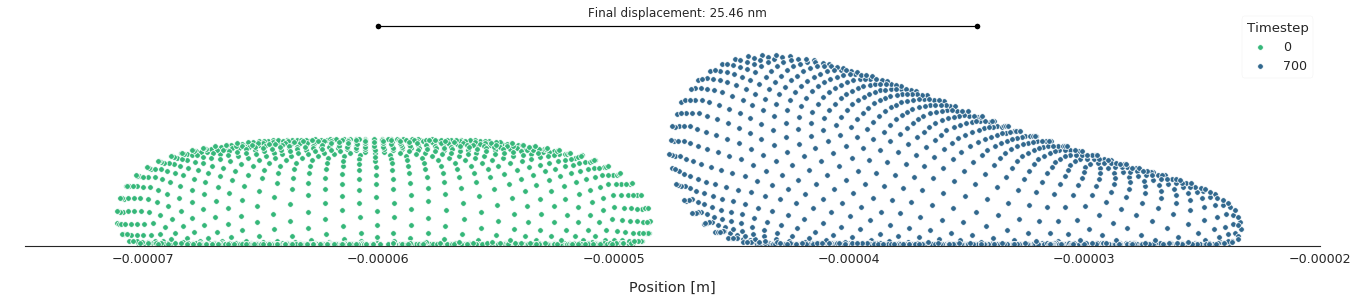

In [286]:
### PLOT NODES - START OF SIMULATION ###
sns.set_style('white')
sns.set_palette('viridis_r',2)
plt.figure(figsize = (8*2.9,1.5*2.9))
# User-defined parameters (sample and timestep)
samp_num = 20
time_num = 0

# Get coordinates from VTK files and plot them
coord = getCoordinates(samp_num, time_num)
plotNodes(samp_num, time_num)

x1 = data[data['sim_num'] == 1][data['samp_num'] == samp_num][data['time'] == time_num*2]['CoM']

time_num = 700

# Get coordinates from VTK files
coord = getCoordinates(samp_num, time_num)
plotNodes(samp_num, time_num)

x2 = data[data['sim_num'] == 1][data['samp_num'] == samp_num][data['time'] == 1400]['CoM']

sns.despine(left = True)
plt.yticks([])
plt.ylabel(' ')
plt.xlabel('Position [m]', labelpad = 15)
plt.legend(title = 'Timestep')
plt.plot([float(x1), float(x2)], [6.5e-6, 6.5e-6],  marker = 'o', color = 'black')
plt.text((float(x2) + float(x1))/2, 6.8e-6, 'Final displacement: ' + str(round((float(x2) - float(x1))*10e5, 2)) + ' nm', fontsize=12, ha = 'center')

/home/ines/python_envs/generic/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/ines/python_envs/generic/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Text(-5.99843e-05,6.8e-06,'Final displacement: 0.08 nm')

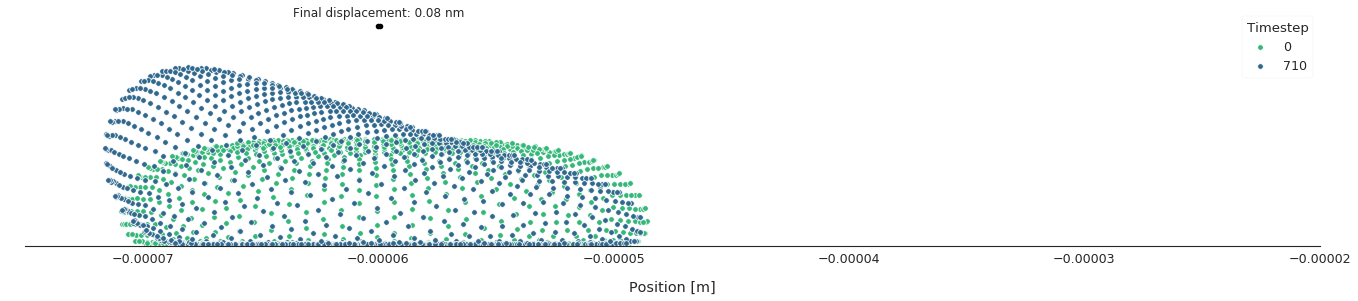

In [282]:
### PLOT NODES - START OF SIMULATION ###
sns.set_style('white')
plt.figure(figsize = (8*2.9,1.5*2.9))
# User-defined parameters (sample and timestep)
samp_num = 1
time_num = 0

# Get coordinates from VTK files and plot them
coord = getCoordinates(samp_num, time_num)
plotNodes(samp_num, time_num)

x1 = data[data['sim_num'] == 1][data['samp_num'] == samp_num][data['time'] == time_num*2]['CoM']

time_num = 710

# Get coordinates from VTK files
coord = getCoordinates(samp_num, time_num)
plotNodes(samp_num, time_num)

x2 = data[data['sim_num'] == 1][data['samp_num'] == samp_num][data['time'] == 1400]['CoM']

sns.despine(left = True)
plt.yticks([])
plt.ylabel(' ')
plt.xlabel('Position [m]', labelpad = 15)
plt.legend(title = 'Timestep')
plt.plot([float(x1), float(x2)], [6.5e-6, 6.5e-6],  marker = 'o', color = 'black')
plt.text((float(x2) + float(x1))/2, 6.8e-6, 'Final displacement: ' + str(round((float(x2) - float(x1))*10e5, 2)) + ' nm', fontsize=12, ha = 'center')

### Total displacement - How much do cells migrate?
One of the questions this study aims to answer is how the stiffness of the ECM and the lifetime of the adhesions affect how much cells migrate. Therefore, a final displacement value was calculated for each sample, considering the last 10 minutes of the simulation, and the values were plotted in the figure below (top image). The mean value and the standard error of the mean (SEM) were also computed, to get a better of how coherent the results are throughout the simulations (bottom image).

Text(0.5,0.98,'Mean and SEM of the final displacement of the 5 simulations')

<Figure size 1440x720 with 0 Axes>

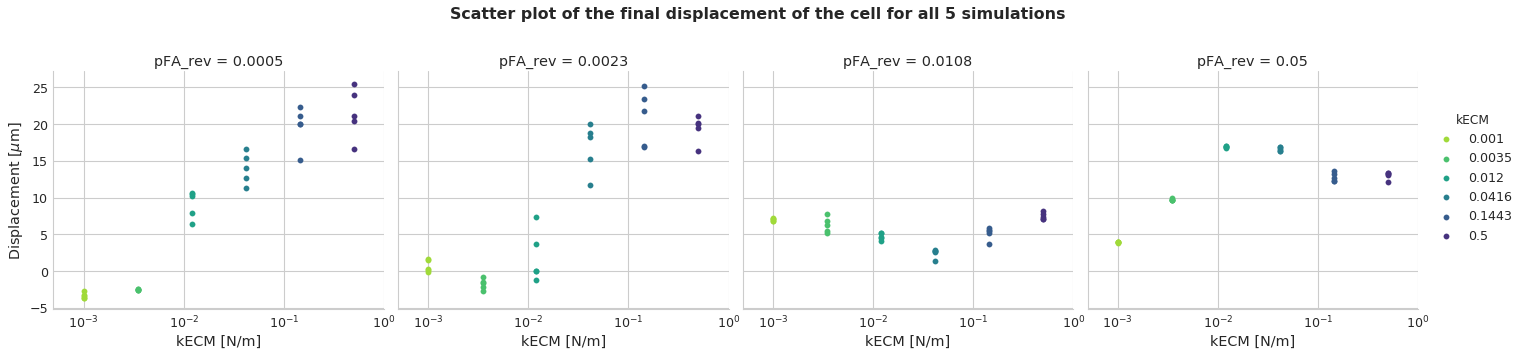

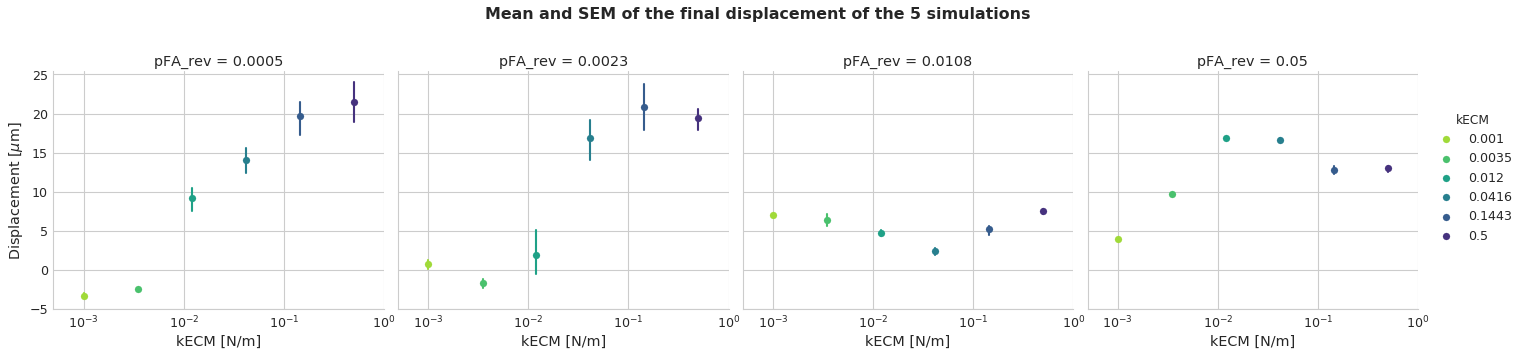

In [278]:
### PLOT DISPLACEMENT - FINAL VALUE ###
plt.figure(figsize = (20, 10))
sns.set_style("whitegrid")
sns.set_palette('viridis_r',6)

g = sns.FacetGrid(data[709::710], col = "pFA_rev", hue = "kECM",  size = 5)

g = (g.map(plt.scatter, "kECM", "final_disp")
    .set(xlim = (50e-5, 10e-1))
    .add_legend()
    .set_axis_labels("kECM [N/m]", "Displacement [$\mu$m]")
    .set(xscale = "log"))

plt.subplots_adjust(top = 0.8)
g.fig.suptitle('Scatter plot of the final displacement of the cell for all 5 simulations', weight = 'bold')

ax = sns.lmplot(data = data[709::710], x = "kECM", y = "final_disp", col = "pFA_rev", hue = "kECM", fit_reg = False, x_estimator = np.mean)
plt.xscale('log')
plt.xlim(50e-5, 10e-1)
plt.subplots_adjust(top = 0.8)
ax.set_xlabels('kECM [N/m]')
ax.set_ylabels('Displacement [$\mu$m]')
plt.suptitle('Mean and SEM of the final displacement of the 5 simulations', weight = 'bold')

/home/ines/python_envs/generic/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/home/ines/python_envs/generic/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/ines/python_envs/generic/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


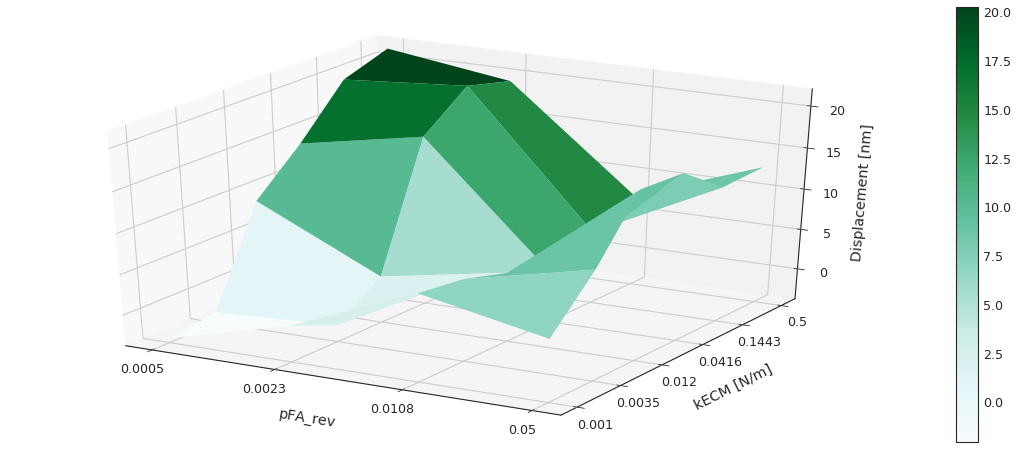

In [352]:
### 3D PLOT ###
fig = plt.figure(figsize = (20,8))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(np.log10(params['pFA_rev'].as_matrix().reshape((6, 4))),
                       np.log10(params['kECM'].as_matrix().reshape((6, 4))), 
                       data.groupby('samp_num')['final_disp'].mean().as_matrix().reshape((6, 4)),
                       cmap='BuGn', linewidths=0)

yticks = [1.0e-3, 3.5e-3, 1.2e-2, 4.16e-2, 1.443e-1, 5.0e-1]
ax.set_yticks(np.log10(yticks))
ax.set_yticklabels(yticks)

xticks = [5e-4, 2.3e-3, 0.0108, 0.05]
ax.set_xticks(np.log10(xticks))
ax.set_xticklabels(xticks)

ax.set_xlabel('pFA_rev', labelpad = 20)
ax.set_ylabel('kECM [N/m]', labelpad = 20)
ax.set_zlabel('Displacement [nm]', labelpad = 10)
fig.colorbar(surf)

### Types of displacement curves - How are cells moving?
Firstly, it is important to have an idea of how the displacement plots look like and how they relate to the actual displacement of the cell.

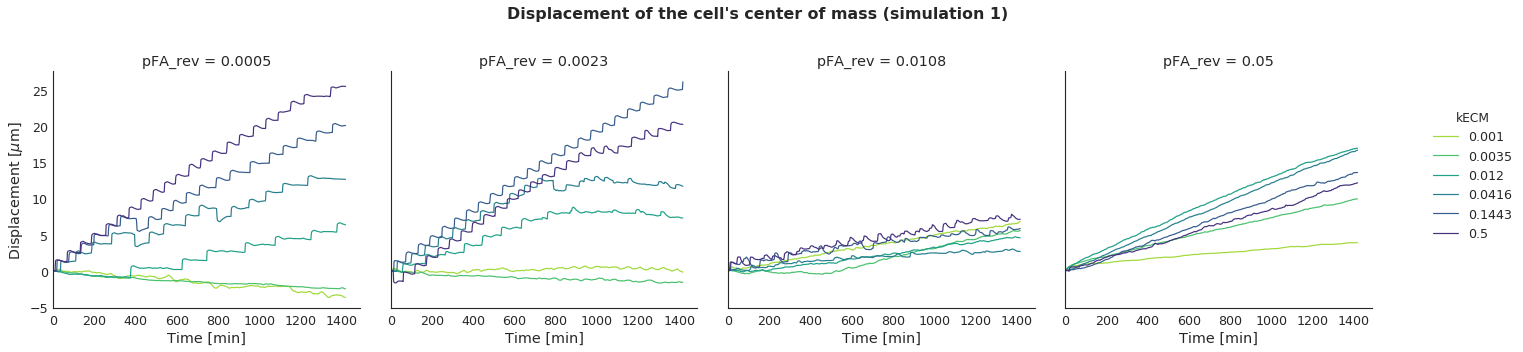

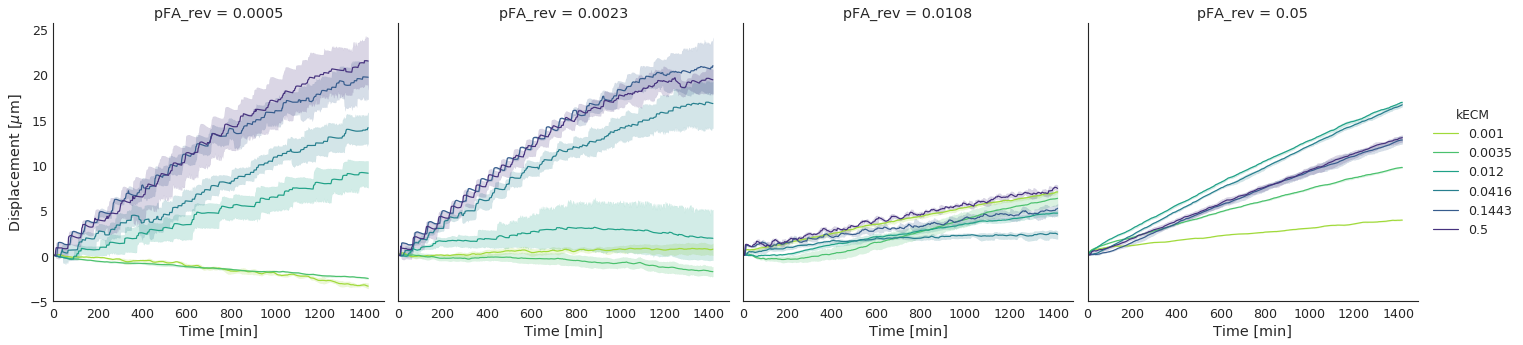

In [334]:
### PLOT DISPLACEMENT - EXAMPLE (SIM 1) ###
sns.set_style("white")
sns.set_palette('viridis_r', 6)

g = sns.FacetGrid(data[data['sim_num'] == 1], col = "pFA_rev", hue = "kECM", margin_titles = True, size = 5)

g = (g.map(plt.plot, "time", "sum_disp")
    .set(xlim = (0, None))
    .add_legend()
    .set_axis_labels("Time [min]", "Displacement [$\mu$m]")
    .fig.subplots_adjust(wspace=.1, hspace=.05))

plt.subplots_adjust(top = .8)
plt.suptitle("Displacement of the cell's center of mass (simulation 1)", weight = 'bold') 

### PLOT DISPLACEMENT - CUMSUM (VARIATION) ###
#sns.set_style("white")
g = sns.FacetGrid(data, col = "pFA_rev", hue = "kECM", size = 5)

g = (g.map(sns.lineplot, "time", "sum_disp")
    .set(xlim = (0, None))
    .add_legend()
    .set_axis_labels("Time [min]", "Displacement [$\mu$m]"))

From the observation of this figure, it is possible to distinguish two main groups in the displacement curves: **those with jumps and those without.** This is a consequence of the type of migration the cell adopts, with the curves with jumps representing a **contraction based** migration (e.g., pFA_rev = 0.0023 and kECM = 0.5), and the curves with no jumps corresponding to a **protrusion driven** migration (e.g., pFA_rev = 0.05 and kECM = 0.012). A plot of each curve type can be found below.

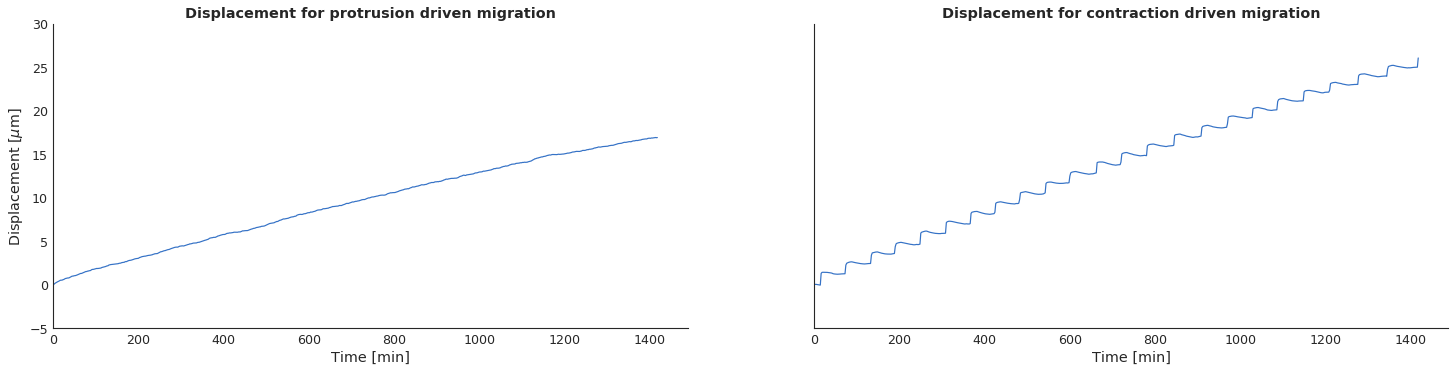

In [24]:
### DISPLACEMENT EXAMPLE PLOT ###
# Figure definition
jtplot.style()
sns.set_style("white")
fig, ax = plt.subplots(1, 2, sharey = True, sharex = True)
fig.set_figwidth(25)

# Plot displacement
ax[0].plot(data["time"][data["sim_num"] == 1][data["samp_num"] == 11], data["sum_disp"][data["sim_num"] == 1][data["samp_num"] == 11])
ax[1].plot(data["time"][data["sim_num"] == 1][data["samp_num"] == 17], data["sum_disp"][data["sim_num"] == 1][data["samp_num"] == 17])

# Figure aesthetics
ax[0].set_ylim(-5, 30)
ax[0].set_ylabel('Displacement [$\mu$m]')
ax[0].set_xlim(0, None)
ax[0].set_xlabel('Time [min]')
ax[1].set_xlabel('Time [min]')
ax[0].set_title('Displacement for protrusion driven migration', weight = 'bold')
ax[1].set_title('Displacement for contraction driven migration', weight = 'bold')
sns.despine(fig)

Nonetheless, this difference is not always as clear as in the examples above, and there are samples for which none of these types is dominant over the other.

In [308]:
### GET ON INFORMATION ON JUMPS - ALL ###
# Set the minimum difference in displacement to be considered a jump
partial_jump_min = 2e-1
full_jump_min = 5e-1

# Define dictionary to store the time values for the jumps of each sample (for all simulations)
sim_jumps = {}

# Define DataFrame to store general information on the jumps for each sample
jumps_info = pd.DataFrame(np.nan, index = range(0, 24*5), columns = ['sim_num', 'samp_num', 'pFA_rev', 'kECM', 'jumps_num', 'full_jump_num', 'partial_jump_num',
                                                                     'first_full_jump', 'jump_time_mean', 'jump_time_std', 'neg_jumps_num'])

# Going through simulations
for s in range(1,6):
    
    # Set variable for sample number
    count = 0
    
    # Define dictionary to store the time values for the jumps of each sample
    sim_specific_jumps = {}
    
    # Going through the samples to store (and print) information on jumps
    for n in range(0, 4):

        for m in range(0,6):

            # Setting a threshold (minimum only, to prevent a small jump appearing next to a big one)
            jumps, _ = find_peaks(abs(data['diff_disp'])[data['sim_num'] == s][data['samp_num'] == count], distance = 15, height = partial_jump_min)

            # Differentiating small and big jumps
            partial_jumps = jumps[abs(data['diff_disp'][data['sim_num'] == s][data['samp_num'] == count].iloc[jumps]) < full_jump_min]
            full_jumps = jumps[abs(data['diff_disp'][data['sim_num'] == s][data['samp_num'] == count].iloc[jumps]) >= full_jump_min]

            # Small adjusment because of the timestep
            partial_jumps = partial_jumps*2
            full_jumps = full_jumps*2  

            # Dictionary with all jumps, partial and full
            jump_values = {}
            
            jump_values['all_jumps'] = jumps*24
            jump_values['partial_jumps'] = partial_jumps
            jump_values['full_jumps'] = full_jumps

            # Store information
            jumps_info['sim_num'][(s - 1)*24 + count] = s
            jumps_info['samp_num'][(s - 1)*24 + count] = count
            jumps_info['jumps_num'][(s - 1)*24 + count] = np.size(jumps) 
            jumps_info['full_jump_num'][(s - 1)*24 + count] = np.size(full_jumps)
            jumps_info['partial_jump_num'][(s - 1)*24 + count] = np.size(partial_jumps) 
            jumps_info['pFA_rev'][(s - 1)*24 + count] = params['pFA_rev'][count]
            jumps_info['kECM'][(s - 1)*24 + count] = params['kECM'][count]
            
            if np.size(jumps) == 0:

                jumps_info['first_full_jump'][(s - 1)*24 + count] = np.nan
                jumps_info['jump_time_mean'][(s - 1)*24 + count] = np.nan
                jumps_info['jump_time_std'][(s - 1)*24 + count] = np.nan
                jumps_info['neg_jumps_num'][(s - 1)*24 + count] = 0
                
            else:
                
                if np.size(full_jumps) == 0:
                    jumps_info['first_full_jump'][(s - 1)*24 + count] = np.nan
                    jumps_info['neg_jumps_num'][(s - 1)*24 + count] = 0
                    
                else:
                    jumps_info['first_full_jump'][(s - 1)*24 + count] = full_jumps[0]
                    jumps_info['neg_jumps_num'][(s - 1)*24 + count] = np.size(full_jumps[data['diff_disp'][data['sim_num'] == s][data['samp_num'] == count].iloc[full_jumps/2] < 0])
                    
                jumps_info['jump_time_mean'][(s - 1)*24 + count] = np.mean(np.diff(jumps))
                jumps_info['jump_time_std'][(s - 1)*24 + count] = np.std(np.diff(jumps))
                
            # Store the jump information in the dictionary, with the sample number as key
            sim_specific_jumps[count] = jump_values

            # Increment sample counter
            count += 1
    
    sim_jumps[s] = sim_specific_jumps

import qgrid
qgrid_widget = qgrid.show_grid(jumps_info)
qgrid_widget

UWdyaWRXaWRnZXQoZ3JpZF9vcHRpb25zPXsnaGlnaGxpZ2h0U2VsZWN0ZWRSb3cnOiBUcnVlLCAnZnVsbFdpZHRoUm93cyc6IFRydWUsICdyb3dIZWlnaHQnOiAyOCwgJ2VuYWJsZUNvbHVtblLigKY=


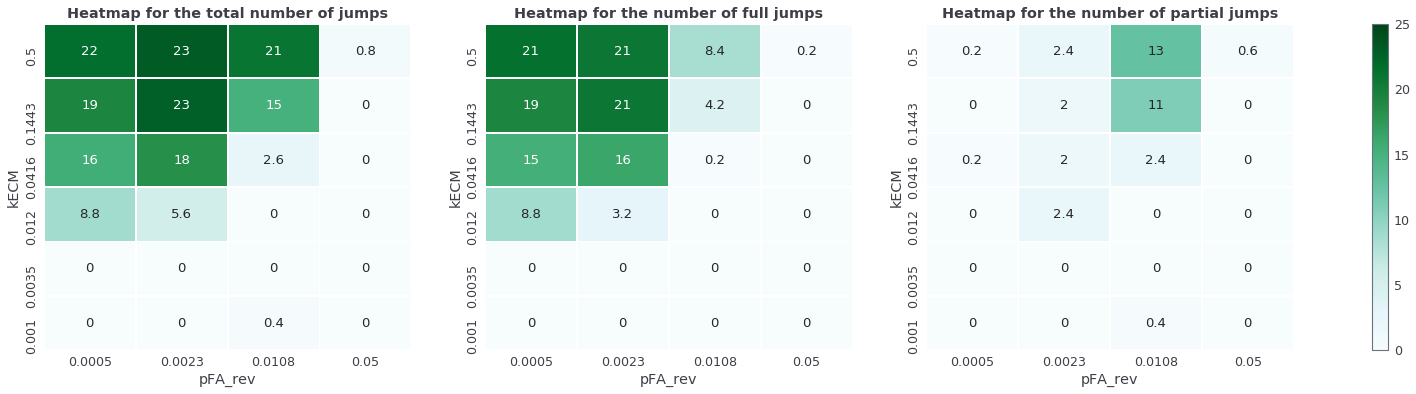

In [313]:
### PLOT HEATMAPS ###
# Figure definition
fig, axes = plt.subplots(1,3)
fig.set_figwidth(28)
fig.set_figheight(6)

# Creating the heatmaps
jump_heatmap = new_jumps_df.pivot('kECM', 'pFA_rev', 'jumps_num')
full_jump_heatmap = new_jumps_df.pivot('kECM', 'pFA_rev', 'full_jump_num')
partial_jump_heatmap = new_jumps_df.pivot('kECM', 'pFA_rev', 'partial_jump_num')

# Plotting the heatmaps (saving colormap to plot colorbar afterwards)
im = sns.heatmap(jump_heatmap, cmap="BuGn", linewidths = .9, annot = True, ax = axes[0], vmax = 25, cbar = False)
sns.heatmap(full_jump_heatmap, cmap="BuGn", linewidths = .9, annot = True, ax = axes[1], vmax = 25, cbar = False)
sns.heatmap(partial_jump_heatmap, cmap="BuGn", linewidths = .9, annot = True, ax = axes[2], vmax = 25, cbar = False)

# Figure aesthetics
axes[0].invert_yaxis()
axes[0].set_title('Heatmap for the total number of jumps', fontweight = 'bold')
axes[1].invert_yaxis()
axes[1].set_title('Heatmap for the number of full jumps', fontweight = 'bold')
axes[2].invert_yaxis()
axes[2].set_title('Heatmap for the number of partial jumps', fontweight = 'bold')

# Colorbar
mappable = im.get_children()[0]
plt.colorbar(mappable, ax=axes)

Text(0.5,1,'Number of "negative" jumps')

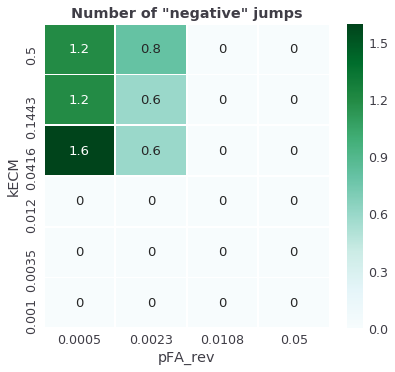

In [318]:
### PLOT HEATMAP OF NUMBER OF JUMPS ###

# Get mean of all simulations
new_jumps_df = jumps_info.groupby('samp_num')['jumps_num'].mean()
new_full_jumps_df = jumps_info.groupby('samp_num')['full_jump_num'].mean()
new_partial_jumps_df = jumps_info.groupby('samp_num')['partial_jump_num'].mean()
new_neg_jumps_df = jumps_info.groupby('samp_num')['neg_jumps_num'].mean()

# Create a new DataFrame with this new data
new_jumps_df = pd.merge(new_jumps_df, new_full_jumps_df, on='samp_num')
new_jumps_df = pd.merge(new_jumps_df, new_partial_jumps_df, on='samp_num')
new_jumps_df = pd.merge(new_jumps_df, new_neg_jumps_df, on='samp_num')
new_jumps_df = pd.merge(new_jumps_df, params, on='samp_num')

# Creating the heatmaps
neg_jump_heatmap = new_jumps_df.pivot('kECM', 'pFA_rev', 'neg_jumps_num')

# Plotting the heatmaps (saving colormap to plot colorbar afterwards)
im = sns.heatmap(neg_jump_heatmap, cmap="BuGn", linewidths = .9, annot = True)
plt.gca().invert_yaxis()
plt.title('Number of "negative" jumps', weight = 'bold')

Text(0.5,1,'Number of FA')

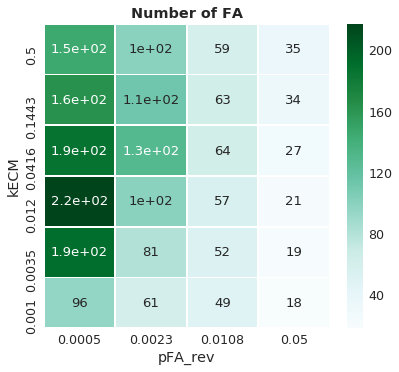

In [351]:
### PLOT HEATMAP OF NUMBER OF JUMPS ##
new_nFA_df = data.dropna().groupby('samp_num')['nFA'].mean()
new_nFA_df = pd.merge(new_nFA_df, params, on='samp_num')

# Creating the heatmaps
neg_jump_heatmap = new_nFA_df.pivot('kECM', 'pFA_rev', 'nFA')

# Plotting the heatmaps (saving colormap to plot colorbar afterwards)
im = sns.heatmap(neg_jump_heatmap, cmap="BuGn", linewidths = .9, annot = True)
plt.gca().invert_yaxis()
plt.title('Number of FA', weight = 'bold')